**MIMIC NLP (AI 395T) - Seth Zapata (shz256)**

# Predicting Medical/Therapeutic Momentum of Patients (MIMIC-IV data)

##Package setup and imports

In [1]:
# pip installations

# Basic DS and ML packages
!pip install pandas numpy matplotlib seaborn scikit-learn

# DL packages
!pip install torch torchvision torchaudio

# Medical text processing
!pip install scispacy
!pip install spacy
!python -m spacy download en_core_sci_md

# For handling medical terminologies
!pip install umls-utils

# For working with time series data
!pip install python-dateutil

# For interactive visualizations
!pip install plotly
!pip install dash

# For notebook enhancements
!pip install ipywidgets
!pip install tqdm


✘ No compatible package found for 'en_core_sci_md' (spaCy v3.7.5)

ERROR: Could not find a version that satisfies the requirement umls-utils (from versions: none)
ERROR: No matching distribution found for umls-utils


In [2]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns
from datetime import datetime, timedelta
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# Set style for visualizations
sns.set_theme()
sns.set_palette("husl")

## Load data and initial view

In [3]:
from google.colab import drive
import pandas as pd

drive.mount('/content/drive')

cohort_id = 'cohort'
medications_id = 'medications'
procedures_id = 'procedures'
labs_id = 'labresults'
vitals_id = 'vitals'

file_path_cohort = '/content/drive/MyDrive/bq-results-' + cohort_id + '/bq-results-' + cohort_id + '.csv'
file_path_medications = '/content/drive/MyDrive/bq-results-' + medications_id + '/bq-results-' + medications_id + '.csv'
file_path_procedures = '/content/drive/MyDrive/bq-results-' + procedures_id + '/bq-results-' + procedures_id + '.csv'
file_path_labs = '/content/drive/MyDrive/bq-results-' + labs_id + '/bq-results-' + labs_id + '.csv'
file_path_vitals = '/content/drive/MyDrive/bq-results-' + vitals_id + '/bq-results-' + vitals_id + '.csv'

# Load MIMIC-IV subset data
cohort_df = pd.read_csv(file_path_cohort)
medications_df = pd.read_csv(file_path_medications)
procedures_df = pd.read_csv(file_path_procedures)
labs_df = pd.read_csv(file_path_labs)
vitals_df = pd.read_csv(file_path_vitals)

# Check initial info
print(cohort_df.head())
print(medications_df.head())
print(procedures_df.head())
print(labs_df.head())
print(vitals_df.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
   subject_id   hadm_id   stay_id           icu_intime          icu_outtime  \
0    16006168  21333517  35290845  2111-01-04 08:04:00  2111-01-05 12:15:25   
1    16006168  29449066  34541667  2111-03-01 04:44:03  2111-03-02 15:01:28   
2    11509003  26752890  39798841  2110-05-05 20:52:00  2110-05-08 15:51:52   
3    10499563  27896354  32084946  2110-11-09 07:04:00  2110-11-10 20:53:06   
4    13688991  29248376  31714139  2110-05-22 10:57:17  2110-05-24 23:42:04   

   icu_length_hours gender  age  
0                28      M   20  
1                35      M   20  
2                67      M   21  
3                37      M   22  
4                61      F   22  
    stay_id            starttime              endtime  itemid      amount  \
0  35806287  2112-01-07 09:02:00  2112-01-07 09:03:00  225799  175.000000   
1  31431293  2111-12-17 17:48:00  2111

## Data pre-processing - Time conversions

In [4]:
# Convert timestamps to datetime for all dataframes
time_columns = ['icu_intime', 'icu_outtime', 'charttime', 'starttime', 'endtime']
for df in [cohort_df, medications_df, procedures_df, labs_df, vitals_df]:
    for col in time_columns:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col])

## Generate time-based windows

In [5]:
def create_time_windows(stay_row, meds_df, procs_df, labs_df, vitals_df, window_hours=24):
    """Create time windows for a single ICU stay with all data types"""
    windows = []
    current_time = stay_row['icu_intime']

    while current_time < stay_row['icu_outtime']:
        window_end = current_time + pd.Timedelta(hours=window_hours)

        # Get all events in this window
        window_meds = meds_df[
            (meds_df['stay_id'] == stay_row['stay_id']) &
            (meds_df['starttime'].between(current_time, window_end))
        ]

        window_procs = procs_df[
            (procs_df['stay_id'] == stay_row['stay_id']) &
            (procs_df['starttime'].between(current_time, window_end))
        ]

        window_labs = labs_df[
            (labs_df['stay_id'] == stay_row['stay_id']) &
            (labs_df['charttime'].between(current_time, window_end))
        ]

        window_vitals = vitals_df[
            (vitals_df['stay_id'] == stay_row['stay_id']) &
            (vitals_df['charttime'].between(current_time, window_end))
        ]

        window_data = {
            'start_time': current_time,
            'end_time': window_end,
            'medications': window_meds,
            'procedures': window_procs,
            'labs': window_labs,
            'vitals': window_vitals
        }

        windows.append(window_data)
        current_time = window_end

    return windows

# Create windows for all ICU stays
print("Creating time windows...")
all_windows = []
for _, row in tqdm(cohort_df.iterrows(), total=len(cohort_df)):
    stay_windows = create_time_windows(row, medications_df, procedures_df, labs_df, vitals_df)
    all_windows.append(stay_windows)

Creating time windows...


  0%|          | 0/1000 [00:00<?, ?it/s]

## Feature Engineering

In [6]:
def calculate_window_features(window):
    """Calculate features from all data types in a window"""
    features = {}

    # Medication features
    features['med_count'] = len(window['medications'])
    features['unique_meds'] = window['medications']['itemid'].nunique() if len(window['medications']) > 0 else 0

    # Procedure features
    features['proc_count'] = len(window['procedures'])
    features['unique_procs'] = window['procedures']['itemid'].nunique() if len(window['procedures']) > 0 else 0

    # Lab features
    if len(window['labs']) > 0:
        lab_stats = window['labs'].groupby('lab_name')['valuenum'].agg(['mean', 'std']).round(2)
        for lab_name, stats in lab_stats.iterrows():
            features[f'lab_{lab_name}_mean'] = stats['mean']
            features[f'lab_{lab_name}_std'] = stats['std']

    # Vital sign features
    if len(window['vitals']) > 0:
        vital_stats = window['vitals'].groupby('vital_name')['valuenum'].agg(['mean', 'std', 'min', 'max']).round(2)
        for vital_name, stats in vital_stats.iterrows():
            features[f'vital_{vital_name}_mean'] = stats['mean']
            features[f'vital_{vital_name}_std'] = stats['std']
            features[f'vital_{vital_name}_min'] = stats['min']
            features[f'vital_{vital_name}_max'] = stats['max']

    return features

# Create feature matrix
print("Extracting features...")
feature_rows = []
for stay_windows in tqdm(all_windows):
    for window in stay_windows:
        feature_rows.append(calculate_window_features(window))

# Convert to DataFrame and handle missing values
features_df = pd.DataFrame(feature_rows)
features_df = features_df.fillna(0)

# Normalize features
scaler = StandardScaler()
features_normalized = scaler.fit_transform(features_df)
features_df = pd.DataFrame(features_normalized, columns=features_df.columns)

print(f"\nFinal feature matrix shape: {features_df.shape}")
display(features_df.head())

Extracting features...


  0%|          | 0/1000 [00:00<?, ?it/s]


Final feature matrix shape: (2294, 288)


,med_count,unique_meds,proc_count,unique_procs,lab_% Hemoglobin A1c_mean,lab_% Hemoglobin A1c_std,lab_Anion Gap_mean,lab_Anion Gap_std,lab_Bicarbonate_mean,lab_Bicarbonate_std,...,lab_Vitamin B12_mean,lab_Vitamin B12_std,lab_Lactate_mean,lab_Lactate_std,lab_Blue Top Hold_mean,lab_Blue Top Hold_std,lab_Valproic Acid_mean,lab_Valproic Acid_std,"lab_Potassium, Whole Blood_mean","lab_Potassium, Whole Blood_std"
0,-0.441331,-0.417743,4.997968,5.844070,20.018530,0.0,6.536490,-0.027738,6.522911,-0.027738,...,-0.020883,0.0,-0.020883,0.0,0.0,0.0,-0.020883,-0.020883,-0.020883,0.0
1,-0.714984,-1.027932,-0.109087,-0.108992,-0.041581,0.0,-0.152167,-0.027738,-0.155861,-0.027738,...,-0.020883,0.0,-0.020883,0.0,0.0,0.0,-0.020883,-0.020883,-0.020883,0.0
2,-0.509744,-0.875384,12.658549,8.820601,-0.041581,0.0,-0.152167,-0.027738,-0.155861,-0.027738,...,-0.020883,0.0,-0.020883,0.0,0.0,0.0,-0.020883,-0.020883,-0.020883,0.0
3,-0.680777,-0.875384,-0.109087,-0.108992,-0.041581,0.0,-0.152167,-0.027738,-0.155861,-0.027738,...,-0.020883,0.0,-0.020883,0.0,0.0,0.0,-0.020883,-0.020883,-0.020883,0.0
4,0.687487,0.344993,-0.109087,-0.108992,-0.041581,0.0,-0.152167,-0.027738,-0.155861,-0.027738,...,-0.020883,0.0,-0.020883,0.0,0.0,0.0,-0.020883,-0.020883,-0.020883,0.0


## Prepare data for model training

In [7]:
# Prepare Data for Model
sequence_length = 2
X, y = [], []

print("Creating sequences...")

current_idx = 0
for stay_windows in tqdm(all_windows):
    if len(stay_windows) > sequence_length:
        for i in range(len(stay_windows) - sequence_length):
            # Get sequence of features
            sequence = features_df.iloc[current_idx + i:current_idx + i + sequence_length]

            # Debug print
            if i == 0:  # Print for first sequence of each stay
                print(f"Sequence shape for stay: {sequence.shape}")

            X.append(sequence.values)

            # Get next window's intervention counts as target
            target_window = stay_windows[i + sequence_length]
            target = calculate_window_features(target_window)
            y.append([
                target['med_count'],
                target['proc_count']
            ])

    current_idx += len(stay_windows)

X = np.array(X)
y = np.array(y)

print(f"\nTotal sequences created: {len(X)}")
print(f"Each sequence shape: {X[0].shape if len(X) > 0 else 'No sequences created'}")

Creating sequences...


  0%|          | 0/1000 [00:00<?, ?it/s]

Sequence shape for stay: (2, 288)
Sequence shape for stay: (2, 288)
Sequence shape for stay: (2, 288)
Sequence shape for stay: (2, 288)
Sequence shape for stay: (2, 288)
Sequence shape for stay: (2, 288)
Sequence shape for stay: (2, 288)
Sequence shape for stay: (2, 288)
Sequence shape for stay: (2, 288)
Sequence shape for stay: (2, 288)
Sequence shape for stay: (2, 288)
Sequence shape for stay: (2, 288)
Sequence shape for stay: (2, 288)
Sequence shape for stay: (2, 288)
Sequence shape for stay: (2, 288)
Sequence shape for stay: (2, 288)
Sequence shape for stay: (2, 288)
Sequence shape for stay: (2, 288)
Sequence shape for stay: (2, 288)
Sequence shape for stay: (2, 288)
Sequence shape for stay: (2, 288)
Sequence shape for stay: (2, 288)
Sequence shape for stay: (2, 288)
Sequence shape for stay: (2, 288)
Sequence shape for stay: (2, 288)
Sequence shape for stay: (2, 288)
Sequence shape for stay: (2, 288)
Sequence shape for stay: (2, 288)
Sequence shape for stay: (2, 288)
Sequence shape

## Create model and start training

In [49]:
class TherapeuticModel(nn.Module):
    def __init__(self, input_size):
        super(TherapeuticModel, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=256,
                           num_layers=1, batch_first=True, dropout=0.2)

         # Separate prediction heads
        self.med_head = nn.Sequential(
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 2)
        )

        self.proc_head = nn.Sequential(
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(32, 2)
        )
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        features = lstm_out[:, -1, :]
        med_pred = self.med_head(features)
        proc_pred = self.proc_head(features)
        return torch.cat([med_pred, proc_pred], dim=1)


In [50]:
# Create weighted loss function
class WeightedMSELoss(nn.Module):
    def __init__(self):
        super(WeightedMSELoss, self).__init__()

    def forward(self, pred, target):
        # Weight medications and procedures
        med_loss = nn.functional.l1_loss(pred[:, 0], target[:, 0])
        proc_loss = nn.functional.l1_loss(pred[:, 1], target[:, 1])
        return med_loss + proc_loss * .5  # Weighting after normalization

## Split train data

In [36]:
# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to tensors
X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train)
X_val = torch.FloatTensor(X_val)
y_val = torch.FloatTensor(y_val)

## Normalization

In [37]:
# First normalize the targets
print("Normalizing targets...")
med_scaler = StandardScaler()
proc_scaler = StandardScaler()

y_train_normalized = np.column_stack([
    med_scaler.fit_transform(y_train[:, 0].reshape(-1, 1)).flatten(),
    proc_scaler.fit_transform(y_train[:, 1].reshape(-1, 1)).flatten()
])
y_val_normalized = np.column_stack([
    med_scaler.transform(y_val[:, 0].reshape(-1, 1)).flatten(),
    proc_scaler.transform(y_val[:, 1].reshape(-1, 1)).flatten()
])

y_train = torch.FloatTensor(y_train_normalized)
y_val = torch.FloatTensor(y_val_normalized)

Normalizing targets...


## Model training

In [54]:
# Instantiate model instance
model = TherapeuticModel(input_size=features_df.shape[1])

# Training parameters
criterion = WeightedMSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005, weight_decay=0.01)
batch_size = 32
num_epochs = 200

# Training loop
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0

    for i in range(0, len(X_train), batch_size):
        batch_X = X_train[i:i+batch_size]
        batch_y = y_train[i:i+batch_size]

        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)

        loss.backward()

        # Add gradient clippping
        max_norm = 1.0
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)

        optimizer.step()

        total_train_loss += loss.item()

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val)
        val_loss = criterion(val_outputs, y_val)

    # Store losses
    train_losses.append(total_train_loss / (len(X_train)/batch_size))
    val_losses.append(val_loss.item())

    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Training Loss: {train_losses[-1]:.4f}')
    print(f'Validation Loss: {val_losses[-1]:.4f}\n')

    #if (epoch + 1) % 10 == 0:
     #   print(f'Epoch [{epoch+1}/{num_epochs}]')
      #  print(f'Training Loss: {train_losses[-1]:.4f}')
       # print(f'Validation Loss: {val_losses[-1]:.4f}\n')

Epoch [1/200]
Training Loss: 0.7483
Validation Loss: 0.5636

Epoch [2/200]
Training Loss: 0.6993
Validation Loss: 0.5625

Epoch [3/200]
Training Loss: 0.6719
Validation Loss: 0.5652

Epoch [4/200]
Training Loss: 0.6652
Validation Loss: 0.5614

Epoch [5/200]
Training Loss: 0.6758
Validation Loss: 0.5558

Epoch [6/200]
Training Loss: 0.6436
Validation Loss: 0.5332

Epoch [7/200]
Training Loss: 0.6518
Validation Loss: 0.5152

Epoch [8/200]
Training Loss: 0.6523
Validation Loss: 0.5087

Epoch [9/200]
Training Loss: 0.6231
Validation Loss: 0.4960

Epoch [10/200]
Training Loss: 0.6099
Validation Loss: 0.5022

Epoch [11/200]
Training Loss: 0.6173
Validation Loss: 0.4934

Epoch [12/200]
Training Loss: 0.6263
Validation Loss: 0.4905

Epoch [13/200]
Training Loss: 0.6070
Validation Loss: 0.4886

Epoch [14/200]
Training Loss: 0.5710
Validation Loss: 0.4857

Epoch [15/200]
Training Loss: 0.5725
Validation Loss: 0.4895

Epoch [16/200]
Training Loss: 0.5769
Validation Loss: 0.4900

Epoch [17/200]
Tr

Medication counts:
Training range: -0.54 to 6.00
Mean: -0.00, Std: 1.00

Procedure counts:
Training range: -0.06 to 15.87
Mean: 0.00, Std: 1.00


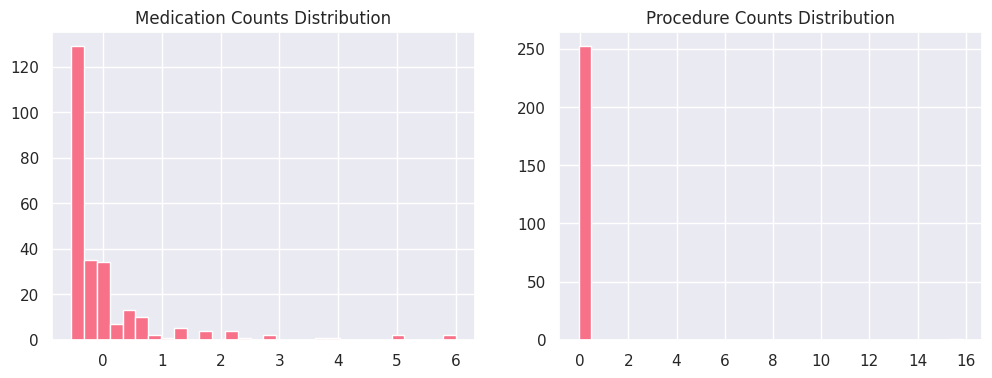

In [55]:
# Check the range and distribution of our targets
print("Medication counts:")
print(f"Training range: {y_train[:, 0].min():.2f} to {y_train[:, 0].max():.2f}")
print(f"Mean: {y_train[:, 0].mean():.2f}, Std: {y_train[:, 0].std():.2f}\n")

print("Procedure counts:")
print(f"Training range: {y_train[:, 1].min():.2f} to {y_train[:, 1].max():.2f}")
print(f"Mean: {y_train[:, 1].mean():.2f}, Std: {y_train[:, 1].std():.2f}")

# Visualize distributions
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(y_train[:, 0].numpy(), bins=30)
plt.title('Medication Counts Distribution')
plt.subplot(1, 2, 2)
plt.hist(y_train[:, 1].numpy(), bins=30)
plt.title('Procedure Counts Distribution')
plt.show()

## Evaluation of model results (with visualization)

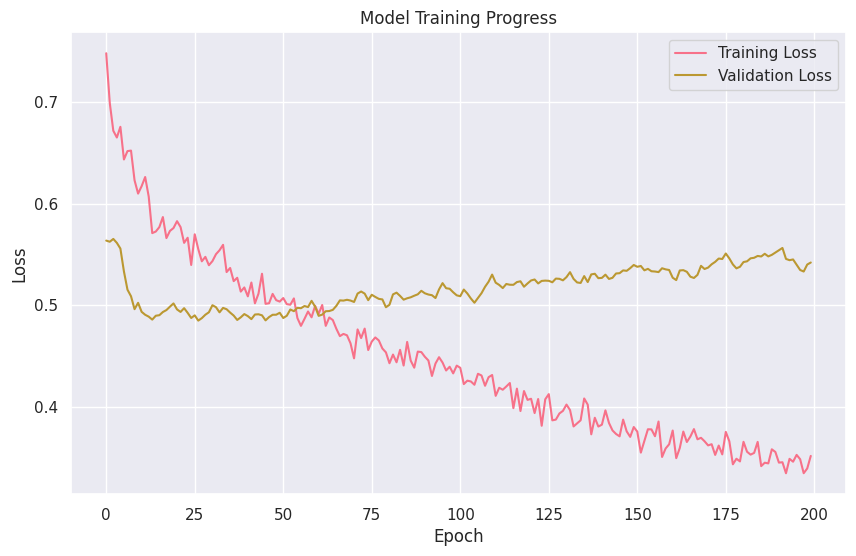

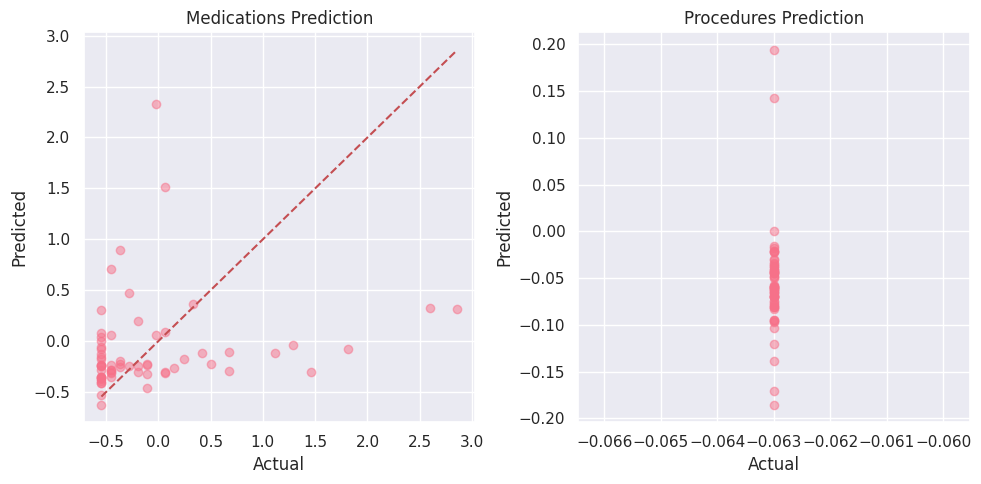

In [59]:
# Plot training progress
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Model Training Progress')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Make predictions on validation set
model.eval()
with torch.no_grad():
    val_predictions = model(X_val).numpy()

# Plot actual vs predicted for each intervention type
intervention_types = ['Medications', 'Procedures']
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

for i, (ax, int_type) in enumerate(zip(axes, intervention_types)):
    ax.scatter(y_val[:, i], val_predictions[:, i], alpha=0.5)
    ax.plot([y_val[:, i].min(), y_val[:, i].max()],
            [y_val[:, i].min(), y_val[:, i].max()],
            'r--')
    ax.set_title(f'{int_type} Prediction')
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')

plt.tight_layout()
plt.show()

## Analysis of Sequence Patterns

Predictions shape: (64, 4)
Actual shape: torch.Size([64, 2])


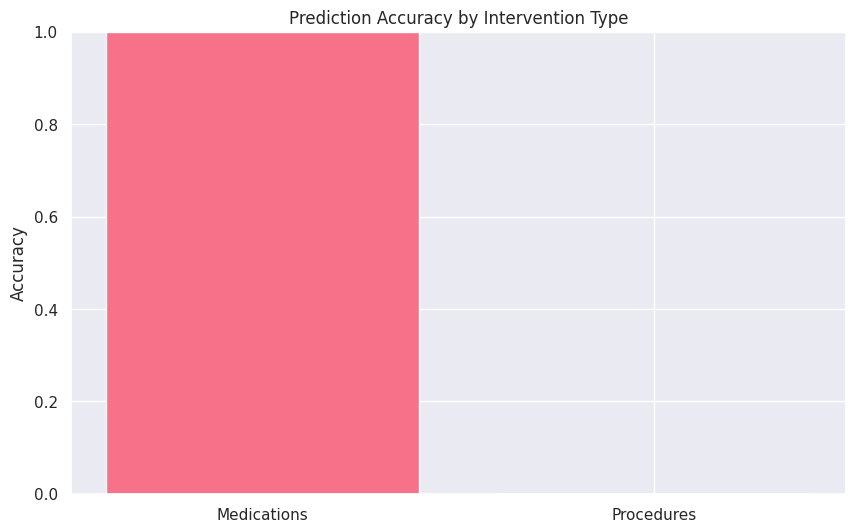


Pattern Analysis Summary:

Medications:
Total occurrences: 64
Correct predictions: 64
Accuracy: 100.00%

Procedures:
Total occurrences: 64
Correct predictions: 0
Accuracy: 0.00%


In [63]:
def analyze_sequences(predictions, actual):
    print(f"Predictions shape: {predictions.shape}")
    print(f"Actual shape: {actual.shape}")

    sequence_patterns = {}

    for i in range(actual.shape[1]):
        actual_type = intervention_types[i]
        sequence_patterns[actual_type] = {'correct': 0, 'total': 0}

        for pred, act in zip(predictions[:, i], actual[:, i]):
            pred_type = intervention_types[int(pred.argmax())]

            sequence_patterns[actual_type]['total'] += 1
            if pred_type == actual_type:
                sequence_patterns[actual_type]['correct'] += 1

    return sequence_patterns

patterns = analyze_sequences(val_predictions, y_val)

# Plot pattern analysis
plt.figure(figsize=(10, 6))
accuracies = {k: v['correct']/v['total'] for k, v in patterns.items()}
plt.bar(accuracies.keys(), accuracies.values())
plt.title('Prediction Accuracy by Intervention Type')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()

# Print summary statistics
print("\nPattern Analysis Summary:")
for int_type, stats in patterns.items():
    print(f"\n{int_type}:")
    print(f"Total occurrences: {stats['total']}")
    print(f"Correct predictions: {stats['correct']}")
    print(f"Accuracy: {stats['correct']/stats['total']:.2%}")

## Intervention patterns

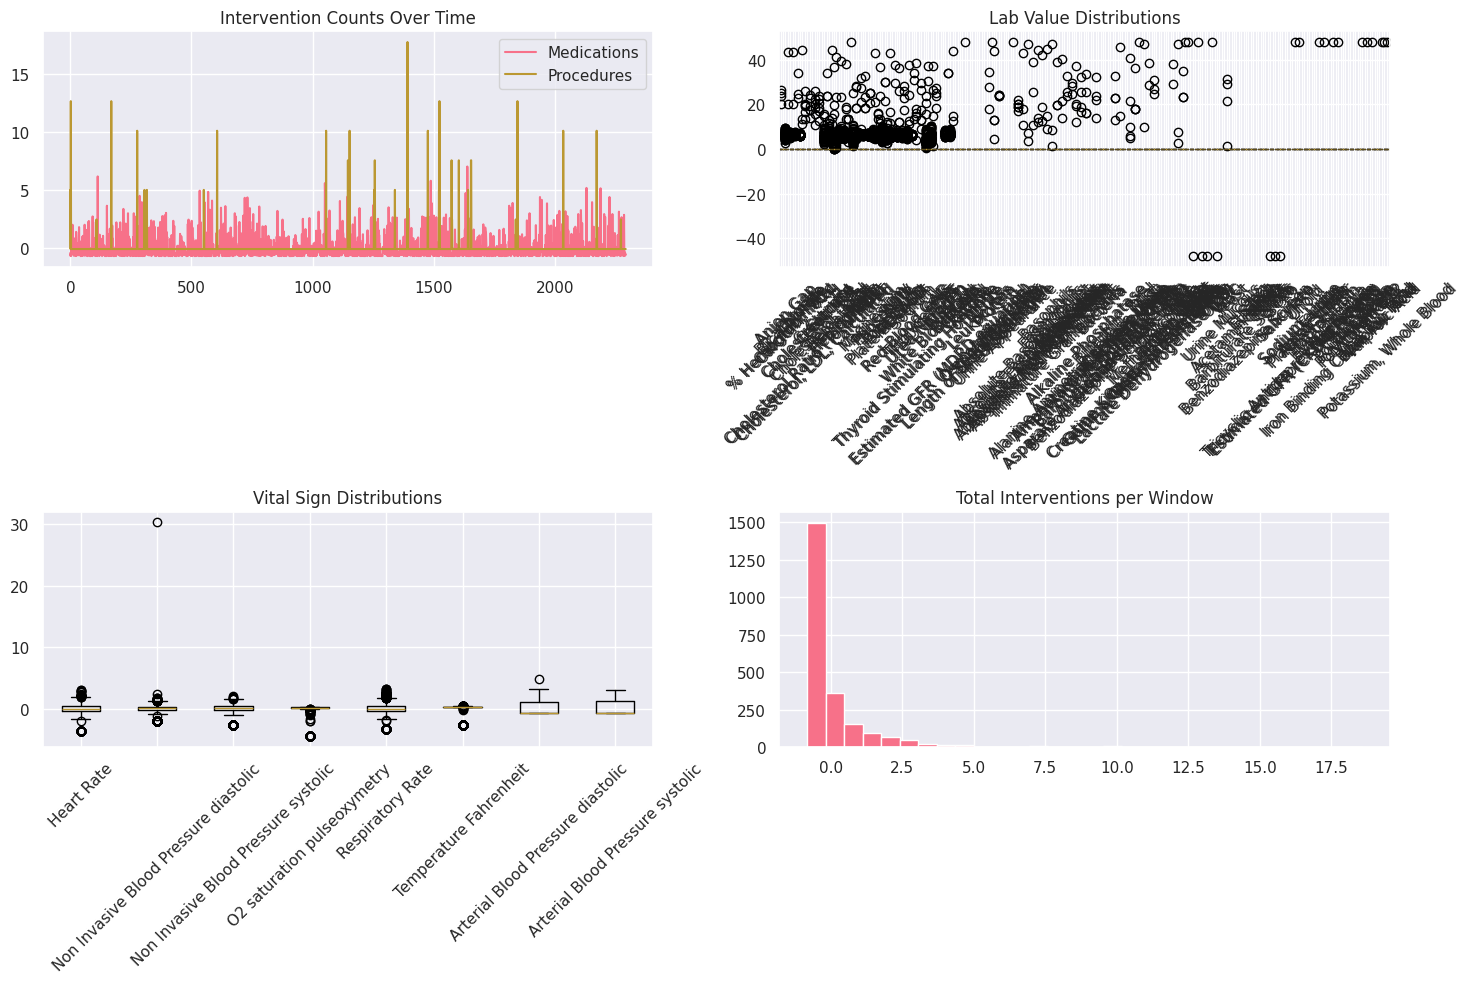

In [64]:
# Plot intervention patterns over time
plt.figure(figsize=(15, 10))

# Medication and procedure counts
plt.subplot(2, 2, 1)
plt.plot(features_df['med_count'], label='Medications')
plt.plot(features_df['proc_count'], label='Procedures')
plt.title('Intervention Counts Over Time')
plt.legend()

# Lab test patterns
plt.subplot(2, 2, 2)
lab_cols = [col for col in features_df.columns if col.startswith('lab_')]
plt.boxplot([features_df[col] for col in lab_cols], labels=[col.split('_')[1] for col in lab_cols])
plt.title('Lab Value Distributions')
plt.xticks(rotation=45)

# Vital sign patterns
plt.subplot(2, 2, 3)
vital_cols = [col for col in features_df.columns if col.startswith('vital_') and col.endswith('_mean')]
plt.boxplot([features_df[col] for col in vital_cols],
            labels=[col.split('_')[1] for col in vital_cols])
plt.title('Vital Sign Distributions')
plt.xticks(rotation=45)

# Overall intervention density
plt.subplot(2, 2, 4)
total_interventions = features_df['med_count'] + features_df['proc_count']
plt.hist(total_interventions, bins=30)
plt.title('Total Interventions per Window')

plt.tight_layout()
plt.show()